In [13]:
from ipynb.fs.full.ModelTraining import *
from sklearn. metrics import (
    classification_report, confusion_matrix, f1_score, 
    precision_score, recall_score, accuracy_score, 
    silhouette_score, calinski_harabasz_score, davies_bouldin_score
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# ============================================================
# 1. PREPARE LABELS FROM ALL MODELS
# ============================================================

# Isolation Forest labels (convert -1/1 to 1/0)
df['iso_label'] = df['anomaly'].map({-1: 1, 1: 0})

# DBSCAN labels
df['dbscan_label'] = df['dbscan_anomaly']

# AdaBoost labels
df['ada_label'] = ada.predict(X_pca)
df['ada_prob'] = ada. predict_proba(X_pca)[:, 1]
df['ada_label'] = df['ada_label'].map({-1: 1, 1: 0})

In [ ]:
# ============================================================
# 2. MODEL AGREEMENT ANALYSIS
# ============================================================

print("=" * 60)
print("MODEL AGREEMENT ANALYSIS")
print("=" * 60)

# Pairwise agreements
models = ['iso_label', 'dbscan_label', 'ada_label']
model_names = ['Isolation Forest', 'DBSCAN', 'AdaBoost']

agreement_matrix = pd. DataFrame(index=model_names, columns=model_names)

for i, m1 in enumerate(models):
    for j, m2 in enumerate(models):
        agreement = (df[m1] == df[m2]).mean()
        agreement_matrix.iloc[i, j] = f"{agreement:.2%}"

print("\nPairwise Agreement Matrix:")
print(agreement_matrix)

# Unanimous agreement (all models agree)
df['unanimous'] = (df['iso_label'] == df['dbscan_label']) & (df['dbscan_label'] == df['ada_label'])
print(f"\nUnanimous Agreement (all 3 models): {df['unanimous'].mean():.2%}")


MODEL AGREEMENT ANALYSIS

Pairwise Agreement Matrix:
                 Isolation Forest   DBSCAN AdaBoost
Isolation Forest          100.00%   99.18%   97.26%
DBSCAN                     99.18%  100.00%   97.42%
AdaBoost                   97.26%   97.42%  100.00%

Unanimous Agreement (all 3 models): 96.93%


In [16]:
# ============================================================
# 3.  CROSS-MODEL EVALUATION METRICS
# ============================================================

def evaluate_models(y_true, y_pred, true_name, pred_name):
    """Evaluate one model against another"""
    print(f"\n{'-'*50}")
    print(f"{pred_name} vs {true_name} (as reference)")
    print(f"{'-'*50}")
    
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"F1 Score:  {f1_score(y_true, y_pred, zero_division=0):.4f}")
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))

print("\n" + "=" * 60)
print("CROSS-MODEL EVALUATION")
print("=" * 60)

# All pairwise comparisons
evaluate_models(df['iso_label'], df['dbscan_label'], 'Isolation Forest', 'DBSCAN')
evaluate_models(df['iso_label'], df['ada_label'], 'Isolation Forest', 'AdaBoost')
evaluate_models(df['dbscan_label'], df['ada_label'], 'DBSCAN', 'AdaBoost')


CROSS-MODEL EVALUATION

--------------------------------------------------
DBSCAN vs Isolation Forest (as reference)
--------------------------------------------------
Accuracy:  0.9918
Precision: 0.6189
Recall:    0.4214
F1 Score:  0.5014

Confusion Matrix:
[[42297   109]
 [  243   177]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     42406
           1       0.62      0.42      0.50       420

    accuracy                           0.99     42826
   macro avg       0.81      0.71      0.75     42826
weighted avg       0.99      0.99      0.99     42826


--------------------------------------------------
AdaBoost vs Isolation Forest (as reference)
--------------------------------------------------
Accuracy:  0.9726
Precision: 0.1896
Recall:    0.5476
F1 Score:  0.2817

Confusion Matrix:
[[41423   983]
 [  190   230]]

Classification Report:
              precision    recall  f1-score   support

          

In [17]:
# ============================================================
# 4. ENSEMBLE / MAJORITY VOTING
# ============================================================

print("\n" + "=" * 60)
print("ENSEMBLE EVALUATION (Majority Voting)")
print("=" * 60)

# Majority vote: anomaly if 2+ models agree
df['majority_vote'] = ((df['iso_label'] + df['dbscan_label'] + df['ada_label']) >= 2).astype(int)

print(f"\nAnomaly Distribution by Majority Vote:")
print(df['majority_vote'].value_counts())
print(f"\nAnomaly Rate (Majority): {df['majority_vote'].mean():.2%}")

# Compare each model to majority vote
for model, name in zip(models, model_names):
    agreement = (df[model] == df['majority_vote']).mean()
    print(f"{name} agreement with Majority Vote: {agreement:.2%}")


ENSEMBLE EVALUATION (Majority Voting)

Anomaly Distribution by Majority Vote:
majority_vote
0    42510
1      316
Name: count, dtype: int64

Anomaly Rate (Majority): 0.74%
Isolation Forest agreement with Majority Vote: 99.51%
DBSCAN agreement with Majority Vote: 99.67%
AdaBoost agreement with Majority Vote: 97.75%


In [18]:
# ============================================================
# 5.  CLUSTERING QUALITY METRICS (Internal Validation)
# ============================================================

print("\n" + "=" * 60)
print("CLUSTERING QUALITY METRICS (Internal Validation)")
print("=" * 60)

def clustering_metrics(X, labels, name):
    """Calculate internal clustering validation metrics"""
    # Filter out noise points for metrics that require >= 2 clusters
    unique_labels = np. unique(labels)
    
    if len(unique_labels) < 2:
        print(f"\n{name}: Only one cluster found, skipping metrics")
        return
    
    print(f"\n{name}:")
    print(f"  Silhouette Score:       {silhouette_score(X, labels):.4f}")
    print(f"  Calinski-Harabasz Index: {calinski_harabasz_score(X, labels):.4f}")
    print(f"  Davies-Bouldin Index:   {davies_bouldin_score(X, labels):.4f}")

# Calculate metrics using PCA-reduced data
clustering_metrics(X_pca, df['iso_label'], 'Isolation Forest')
clustering_metrics(X_pca, df['dbscan_label'], 'DBSCAN')
clustering_metrics(X_pca, df['ada_label'], 'AdaBoost')
clustering_metrics(X_pca, df['majority_vote'], 'Majority Vote Ensemble')


CLUSTERING QUALITY METRICS (Internal Validation)

Isolation Forest:


  Silhouette Score:       0.7219
  Calinski-Harabasz Index: 3464.8419
  Davies-Bouldin Index:   1.3529

DBSCAN:
  Silhouette Score:       0.7159
  Calinski-Harabasz Index: 2747.6020
  Davies-Bouldin Index:   1.1713

AdaBoost:
  Silhouette Score:       0.5725
  Calinski-Harabasz Index: 3341.9337
  Davies-Bouldin Index:   1.5527

Majority Vote Ensemble:
  Silhouette Score:       0.7442
  Calinski-Harabasz Index: 3207.6051
  Davies-Bouldin Index:   1.3189


In [19]:
# ============================================================
# 6. ANOMALY DISTRIBUTION SUMMARY
# ============================================================

print("\n" + "=" * 60)
print("ANOMALY DISTRIBUTION SUMMARY")
print("=" * 60)

summary = pd.DataFrame({
    'Model': model_names + ['Majority Vote'],
    'Total Anomalies': [
        df['iso_label']. sum(),
        df['dbscan_label']. sum(),
        df['ada_label']. sum(),
        df['majority_vote']. sum()
    ],
    'Anomaly Rate': [
        f"{df['iso_label'].mean():.2%}",
        f"{df['dbscan_label'].mean():.2%}",
        f"{df['ada_label']. mean():.2%}",
        f"{df['majority_vote'].mean():.2%}"
    ]
})
print(summary. to_string(index=False))


ANOMALY DISTRIBUTION SUMMARY
           Model  Total Anomalies Anomaly Rate
Isolation Forest              420        0.98%
          DBSCAN              286        0.67%
        AdaBoost             1213        2.83%
   Majority Vote              316        0.74%


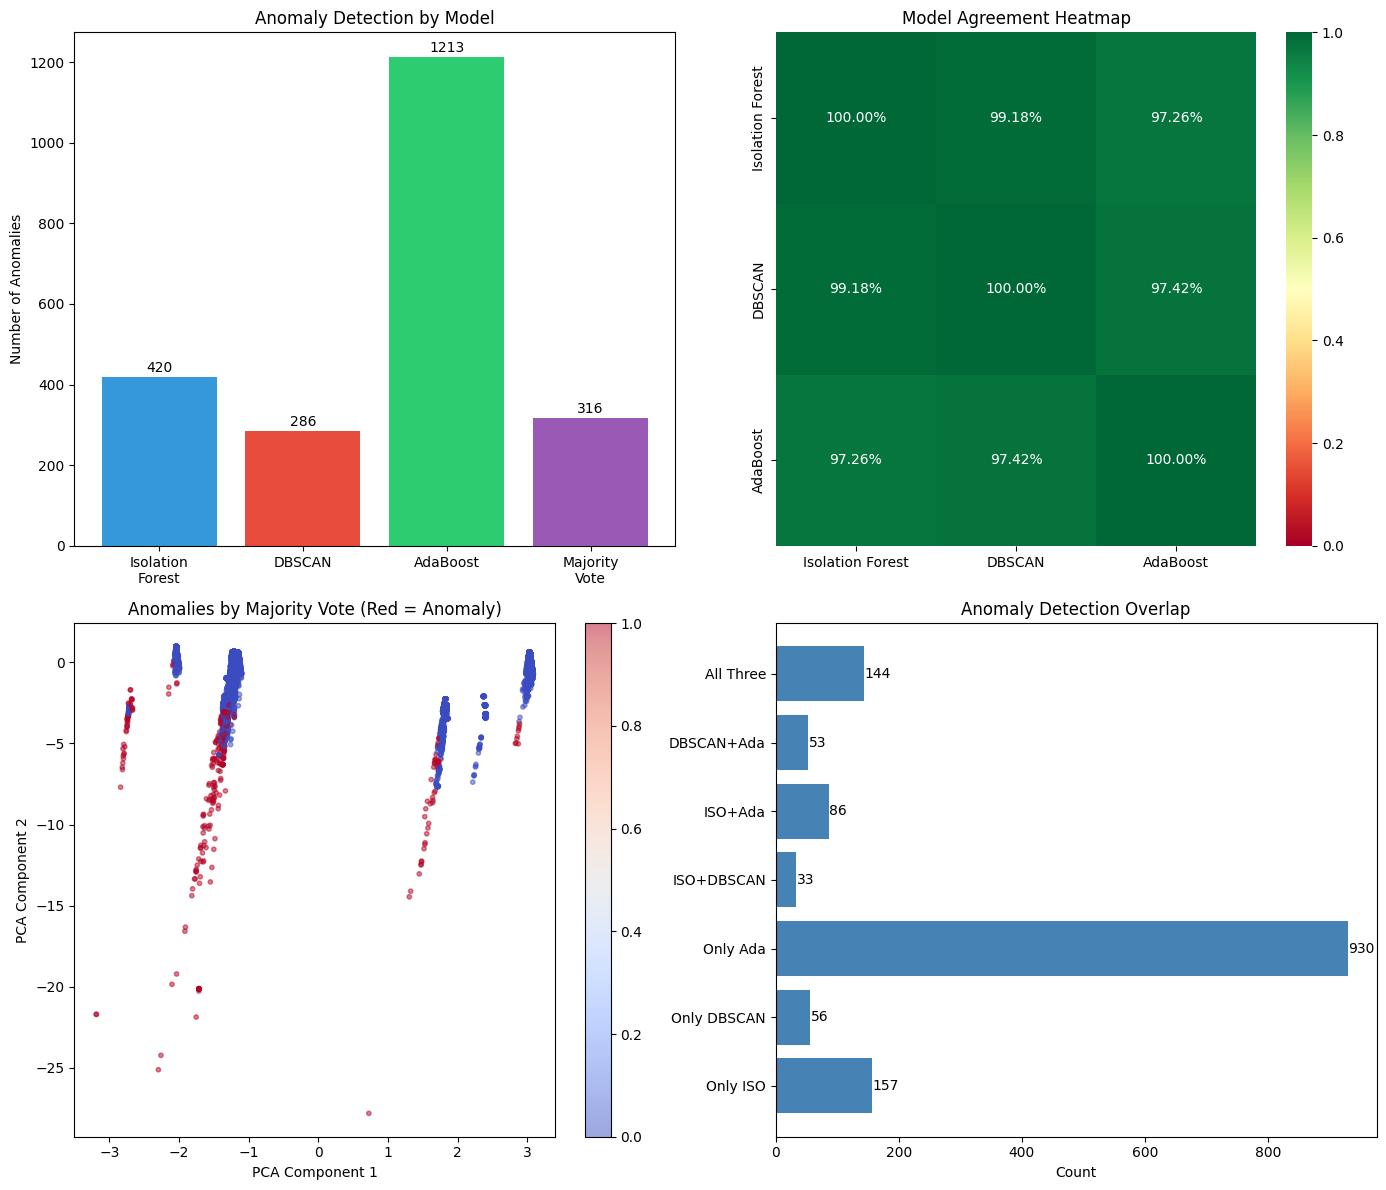


✅ Evaluation complete!  Visualization saved to 'unsupervised_evaluation.png'


In [20]:
# ============================================================
# 7. VISUALIZATION
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Anomaly counts per model
ax1 = axes[0, 0]
anomaly_counts = [df['iso_label'].sum(), df['dbscan_label'].sum(), 
                  df['ada_label'].sum(), df['majority_vote'].sum()]
bars = ax1.bar(['Isolation\nForest', 'DBSCAN', 'AdaBoost', 'Majority\nVote'], 
               anomaly_counts, color=['#3498db', '#e74c3c', '#2ecc71', '#9b59b6'])
ax1.set_ylabel('Number of Anomalies')
ax1.set_title('Anomaly Detection by Model')
for bar, count in zip(bars, anomaly_counts):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             str(count), ha='center', va='bottom')

# Plot 2: Agreement Heatmap
ax2 = axes[0, 1]
agreement_numeric = pd.DataFrame(index=model_names, columns=model_names, dtype=float)
for i, m1 in enumerate(models):
    for j, m2 in enumerate(models):
        agreement_numeric.iloc[i, j] = (df[m1] == df[m2]).mean()
sns.heatmap(agreement_numeric. astype(float), annot=True, fmt='.2%', 
            cmap='RdYlGn', ax=ax2, vmin=0, vmax=1)
ax2.set_title('Model Agreement Heatmap')

# Plot 3: PCA Scatter with Majority Vote
ax3 = axes[1, 0]
scatter = ax3.scatter(X_pca[:, 0], X_pca[:, 1], c=df['majority_vote'], 
                      cmap='coolwarm', alpha=0.5, s=10)
ax3. set_xlabel('PCA Component 1')
ax3.set_ylabel('PCA Component 2')
ax3.set_title('Anomalies by Majority Vote (Red = Anomaly)')
plt.colorbar(scatter, ax=ax3)

# Plot 4: Venn-style overlap analysis
ax4 = axes[1, 1]
overlap_data = {
    'Only ISO': ((df['iso_label'] == 1) & (df['dbscan_label'] == 0) & (df['ada_label'] == 0)). sum(),
    'Only DBSCAN': ((df['iso_label'] == 0) & (df['dbscan_label'] == 1) & (df['ada_label'] == 0)).sum(),
    'Only Ada': ((df['iso_label'] == 0) & (df['dbscan_label'] == 0) & (df['ada_label'] == 1)).sum(),
    'ISO+DBSCAN': ((df['iso_label'] == 1) & (df['dbscan_label'] == 1) & (df['ada_label'] == 0)).sum(),
    'ISO+Ada': ((df['iso_label'] == 1) & (df['dbscan_label'] == 0) & (df['ada_label'] == 1)).sum(),
    'DBSCAN+Ada': ((df['iso_label'] == 0) & (df['dbscan_label'] == 1) & (df['ada_label'] == 1)).sum(),
    'All Three': ((df['iso_label'] == 1) & (df['dbscan_label'] == 1) & (df['ada_label'] == 1)).sum(),
}
ax4.barh(list(overlap_data.keys()), list(overlap_data.values()), color='steelblue')
ax4.set_xlabel('Count')
ax4. set_title('Anomaly Detection Overlap')
for i, v in enumerate(overlap_data.values()):
    ax4. text(v + 1, i, str(v), va='center')

plt.tight_layout()
plt.savefig('unsupervised_evaluation.png', dpi=150)
plt.show()

print("\n✅ Evaluation complete!  Visualization saved to 'unsupervised_evaluation.png'")